# 21M.387 Fundamentals of Music Processing
## Pset7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)

## Exercise 1

Write the function `make_binary_checkerboard`, to create a binary checkboard kernel, similar to the one described in pg 209 of the text. However, in this case, create an even-length checkerboard with dimensions $(M \times M)$. The input is the "half length" or $L$ such that $M = 2L$.

The checkerboard is divided into 4 equal $(L \times L)$ square regions such that, assuming $(0,0)$ is the bottom left:
- the bottom-left and top-right regions are set to $1$.
- the top-left and bottom-right regions are set to $-1$.

Make a checkerboard with $L=10$ and display it (using `plt.imshow()` with `origin='lower'`)

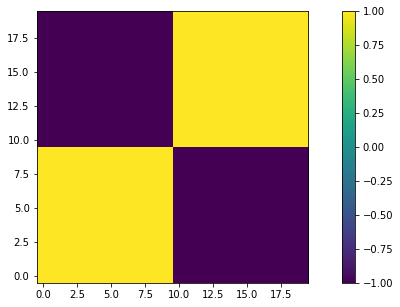

In [46]:
def make_binary_checkerboard(hlen):
    ones = np.full((hlen,hlen),1)
    top = np.hstack([-1*ones,ones])
    return np.vstack([-1*top,top])

def make_binary_checkerboard_fancier(hlen):
    y_ind,x_ind = np.mgrid[0:2*hlen,0:2*hlen]
    xor = np.logical_xor(y_ind>=hlen,x_ind>=hlen)
    return np.vectorize(lambda b:-1 if b else 1)(xor)

def make_binary_checkerboard_fanciest(hlen):
    y,x=np.mgrid[0:2*hlen,0:2*hlen]>=hlen
    return -2*((x^y).astype(int)-0.5) #magic

plt.imshow(make_binary_checkerboard(10),origin='lower')
#plt.imshow(make_binary_checkerboard_fancier(10),origin='lower')
#plt.imshow(make_binary_checkerboard_fanciest(10),origin='lower')
plt.colorbar()

## Exercise 2a

Create a 2D Gaussian matrix $\phi$ whose value is highest in the center and then falls off radially as a Gaussian distribution. The input to the function, `wlen`, is $M$, the desired width and height of the matrix. The result should be a symmetric square matrix with the following values:

$$\phi(n, m) = exp(- \epsilon^2 ((n-c)^2 + (m-c)^2) $$

- $n \in [0, M-1]$
- $m \in [0, M-1]$
- $\epsilon = {2 \over M}$
- Find the correct value for $c$ such that the matrix is perfectly symmetric (hint: when $M$ is even, the middle 4 cell values should all be equal)

Plot the results with $M=20$

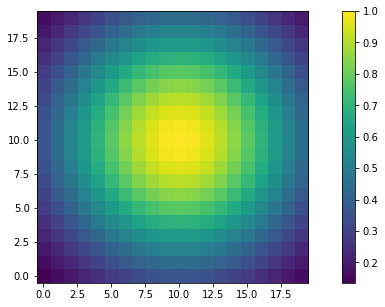

In [47]:
def make_2D_gaussian(wlen):
    M = float(wlen)
    eps, c = 2.0/M, M/2.0
    y_ind,x_ind = np.mgrid[0:wlen, 0:wlen]
    def phi(n,m):
        y_diff, x_diff = n-c, m-c
        return np.e**((-eps**2)*(y_diff**2+x_diff**2))
    apply_phi = np.vectorize(lambda n,m: phi(n,m))
    return apply_phi(y_ind, x_ind)

gaussian = make_2D_gaussian(20)
plt.imshow(gaussian, origin='lower')
plt.colorbar()

## Exercise 2b

Use the two functions above to create a new function, `make_gaussian_checkerboard(hlen)`, that makes a tapered checkerboard, similar to Figure 4.23c of the text (but without the middle zero values).

Plot the result for a $M = 2L = 20$. `hlen` is the half-length $L$.


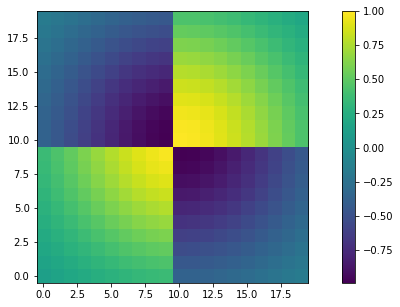

In [48]:
def make_gaussian_checkerboard(hlen):
    return make_2D_gaussian(2*hlen) * make_binary_checkerboard(hlen)

checkerboard = make_gaussian_checkerboard(10)
plt.imshow(checkerboard,origin='lower')
plt.colorbar()


## Exercise 3

Create the function `make_checkerboard_novelty(ssm, cb_hlen)` whose inputs are:
- $\mathbf{S}$, the SSM and 
- $L$, the half-length parameter for generating $\mathbf{K}$, the checkerboard kernel.

The function computes the diagonal novelty curve
by sliding $\mathbf{K}$ along the diagonal of $\mathbf{S}$. At each step, record the sum of the point-wise multiplication between $\mathbf{K}$ and the overlapping portion of $\mathbf{S}$. This will generate $\Delta(n)$:

$$\Delta(n) = \sum_{k,l \in [0:L-1]} \mathbf{K}(k,l) \mathbf{S}(n-L+k, n-L+l)$$

In order to handle the out-of-range indexing of $\mathbf{S}$, you should zero-pad the entire matrix with $L$ zeros on all sides.

In [49]:
def make_checkerboard_novelty(ssm, cb_hlen):
    cb_hlen = 10
    ssm = np.load('data/ex3.npy')
    pad_ssm = np.zeros((2*cb_hlen+ssm.shape[0], 2*cb_hlen+ssm.shape[1]))
    pad_ssm[cb_hlen:cb_hlen+ssm.shape[0], cb_hlen:cb_hlen+ssm.shape[1]] = ssm

    cb = make_gaussian_checkerboard(cb_hlen)
    nov = []
    for diag_i in range(ssm.shape[1]):
        nov.append(np.sum(cb*pad_ssm[diag_i:diag_i+2*cb_hlen,
                                     diag_i:diag_i+2*cb_hlen]))
    return np.array(nov)



Test your function by creating the boundary novelty curve on the following synthetic SSM. 
- Plot the SSM
- Plot the resulting boundary novelty curve.

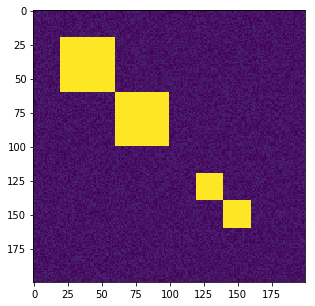

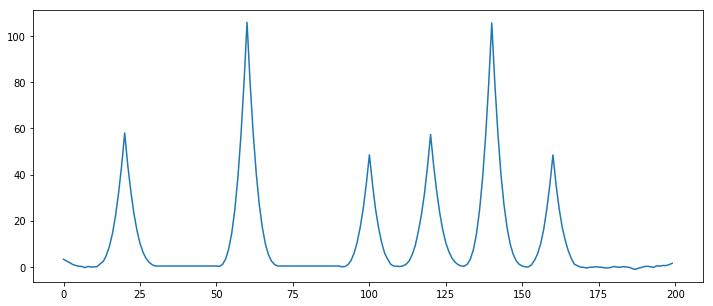

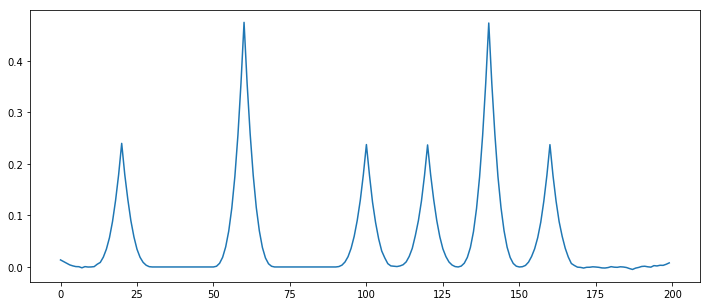

In [50]:
ssm = np.load('data/ex3.npy')
cb_hlen = 10

nov = make_checkerboard_novelty(ssm, cb_hlen)
nov_check = fmp.diagonal_novelty(ssm, cb_hlen)
    
plt.imshow(ssm)
plt.figure()
plt.plot(nov)
plt.figure()
plt.plot(nov_check)


## Exercise 4

The following are two sequences of song boundaries:

- `est` is an algoritmicly generated estimate of song boundaries and is given as sample locations at a feature rate of 10Hz.
- `ref` is the ground truth / reference annotaiton, given in seconds.

Plot these two sequences on the same plot using `plt.vlines` so you can see how they compare. Of course, for the comparison to make sense, they need to be on the same time scale.

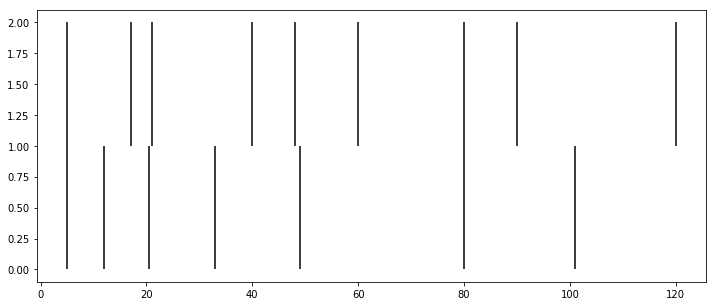

In [11]:
est, ref = np.load('data/ex4.npy')
ff = 10.

#in plots want to plot vertical lines, need to be same time-scale
plt.figure()
plt.vlines(ref,1,2) #reference on top
plt.vlines(est/ff,0,1) #feat num * (1 sec/10 feat num) = feat sec


## Exercise 5

Write the function `compare_boundaries(est, ref, tau)` with inputs:

- `est`: an `np.array` of estimated boundary locations
- `ref`: an `np.array` of the ground truth boundary locations
- `tau`: the distance metric used to determine a match

Return a tuple of three numbers:

- the number of True Positives
- the number of False Positives
- the number of False Negatives

When comparing an estimated point $b^{\text{Est}}$ and reference point $b^{\text{Ref}}$, consider
$$\vert b^{\text{Est}} - b^{\text{Ref}} \vert < \tau$$
as an indication of a match.

Caution: careful not to double count matches in cases where two estimates $b^{\text{Est}}_i$ and $b^{\text{Est}}_j$ are both close to the same $b^{\text{Ref}}$. In this case, one estimate should count as a True Positive, while the other as a False Positive.

In [51]:
def close_enough(r,e,tau): return abs(r-e)<tau

def compare_boundaries(est, ref, tau):
    already_referred = set()
    tp, fp = 0,0
    for e in est: #e == 5
        for r in ref: #r == 5 
            if r not in already_referred and close_enough(e,r,tau):
                tp += 1
                already_referred.add(r)
                break
        if r not in already_referred:
            fp += 1 #if no match for all r
    fn = len(ref) - len(already_referred)
    return (tp,fp,fn)
    

What are the True Positive, False Positive, and False Negative counts for the Exercise 4 estimate and reference sequences using $\tau = 3$ seconds?

tp: 4, fp: 3, fn: 5


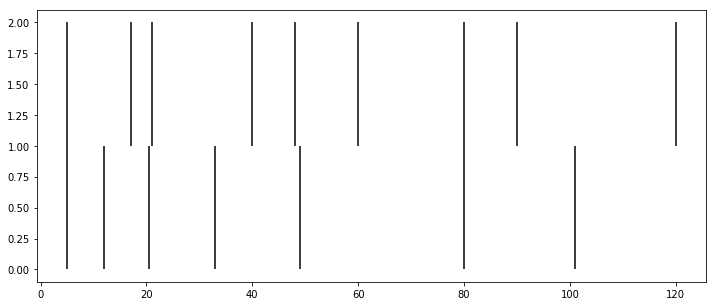

In [52]:
tau = 3.0
(tp,fp,fn) = compare_boundaries(est/float(ff), ref, tau)    
print "tp: %i, fp: %i, fn: %i" % (tp,fp,fn)

plt.figure()
plt.vlines(ref,1,2) #reference on top
plt.vlines(est/ff,0,1) #feat num * (1 sec/10 feat num) = feat sec


## Exercise 6

Write that returns the Precision, Recall, and F-Measure of two boundary sequences. This function can make use of the `compare_boundaries` above.

Inputs: same as in Exercise 5

Outputs:
A tuple of the calculated values for Precision, Recall, and F-measure

Print out the values of Precision, Recall, and F-measure for the above sequences.

In [53]:
def precision(tp,fp): return tp/float(tp+fp)
def recall(tp,fn): return tp/float(tp+fn)
def f_meas(P,R): return 2*P*R/float(P+R)
def calc_boundaries_PRF(est, ref, tau):
    (tp,fp,fn) = compare_boundaries(est/ff, ref, tau)
    P,R = precision(tp,fp),recall(tp,fn)
    return (P,R,f_meas(P,R))

print "P: %.4f, R: %.4f, F: %.4f" % calc_boundaries_PRF(est/float(ff), ref, tau)

P: 0.1429, R: 0.1111, F: 0.1250


## Exercise 7

In the following three exercises, you will create a system for optimizing some of the parameters of the "sliding checkerboard" boundary detection using some of _The Beatles_ ground truth set.

Create the function `song_boundary_score()`:
Inputs:
- `wav_file`: the name of the wave file
- `ref_file`: the name of the reference annotation file
- `cens_filt_len`: the length of the filter for the CENS chromagram
- `cb_len`: the half-length of the checkerboard
- `thresh`: the threshold parameter for peak finding.

Output: 
- the F-measure score of the estimated boundaries versus the reference annotations.

Calling this function with different values for the three tuning parameters will produce different scores.

Additional Notes:
- For SSM creation, use the helper function you made in lab: `audio_to_ssm(snd, cens_filter_len, cens_ds)`. Use a downsample rate (`cens_ds`) of $1/4$ of the CENS filter length (rounded to an int).
- Use the checkerboard novelty method to create a boundaries novelty curve.
- Use `fmp.find_peaks2` to find peaks (ie, boundary estimates) with a window length of 10 seconds (caution! 10 seconds, not 10 samples) and the threshold `thresh`.
- Use `fmp.load_boundary_annotations(file)` to load the reference annotations. This function returns boundary locations in units of seconds.
- Use $\tau = 3$ seconds for the F-measure calucation.
- It is pretty useful to have this function generate some plots to help you see and debug what's going on. The last argument should only generate plots if True. Normally, it will not generate plots and just return the resulting F-measure.

In [87]:
fs = 22050 
fft_len = 4096
hop_size = fft_len / 2    

def audio_to_ssm(snd, cens_filt_len, cens_ds):
    chroma = fmp.make_chromagram(snd, fs, fft_len, hop_size, 0)
    cens_chroma = fmp.cens(chroma, cens_filt_len, cens_ds)
    return cens_chroma

def song_boundary_score(wav_file, ref_file, cens_filt_len, cb_len, thresh, plot=False):
    cb_hlen = cb_len/2
    snd = load_wav(wav_file)
    ff = fs/hop_size
    
    cens_ds = cens_filt_len/4
    ssm = audio_to_ssm(snd, cens_filt_len, cens_ds)
    nov = make_checkerboard_novelty(ssm, cb_hlen)
    ref = fmp.load_boundary_annotations(ref_file) # in sec
    est = fmp.find_peaks2(nov, ff, thresh)
    
    if plot:
    
        plt.figure()
        plt.plot(nov)
        plt.plot(est, nov[est], 'ro')
    
        #in plots want to plot vertical lines, need to be same time-scale
        plt.figure()
        plt.vlines(ref,1,2) #reference on top
        plt.vlines(est,0,1) #feat num * (1 sec/10 feat num) = feat sec

    tau = 3.0
    (tp,fp,fn) = compare_boundaries(est, ref, tau)    
    P = tp/float(tp+fp)
    R = tp/float(tp+fn)
    return f_meas(P,R)




Try with some examples:

0.266666666667
0.266666666667


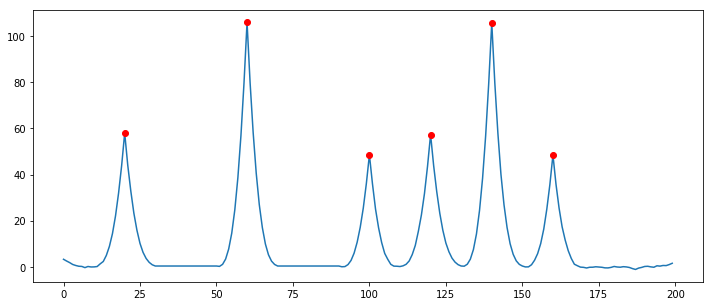

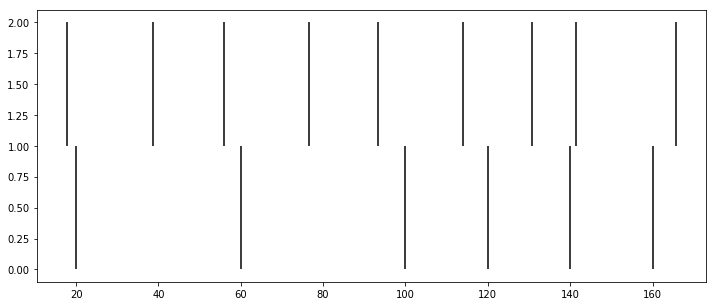

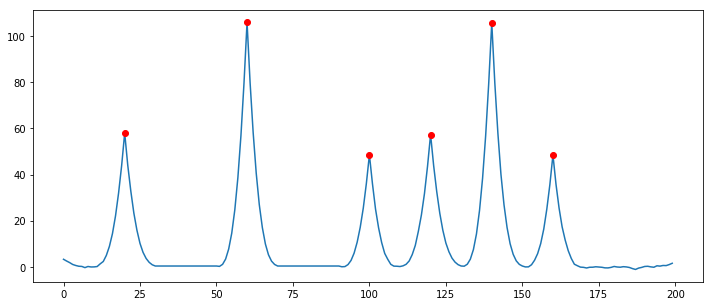

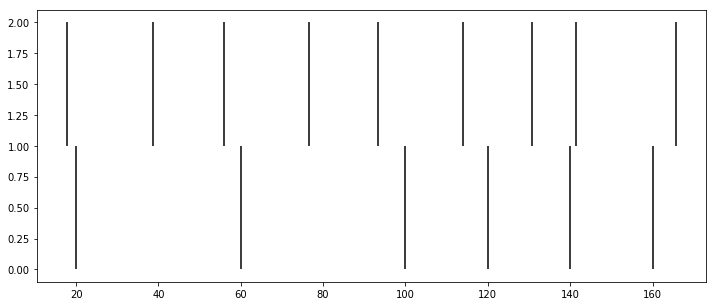

In [88]:
wav_file = "beatles/beatles_hello_goodbye.wav"
ref_file = "beatles/beatles_hello_goodbye.lab"

#song_boundary_score(wav_file, ref_file, cens_filt_len, cb_len, thresh, plot=False)

print song_boundary_score(wav_file, ref_file, 30, 10, .3, True)
print song_boundary_score(wav_file, ref_file, 50, 5, .2, True)

## Exercise 8

You will now run the above test automatically on a collection of songs. It is important to test on a large number of songs to get confidence in our algorithm and parameter choices. 

Write the function `average_boundary_score`, to compute the average F-measure score over all the songs in the `beatles` directory with the a particular set of parameters. The inputs are:
- `cens_filt_len`: the length of the filter for the CENS chromagram
- `cb_len`: the half-length of the checkerboard
- `thresh`: the threshold parameter for peak finding.

The function returns the average F-measure of all songs in the beatles directory.

To automate finding all files in a directory, you will find the functions `os.listdir()` and `os.path.join()` useful. To test if a file is a `wav` file, you can use the string method `endswith`.

In [91]:
import os, os.path

def average_boundary_score(cens_filt_len, cb_len, thresh):
    files = os.listdir('./beatles')
    wavs = sorted(['./beatles/'+x for x in files if x.endswith('wav')])
    refs = sorted(['./beatles/'+x for x in files if x.endswith('lab')])
    scores = [song_boundary_score(wav_file, ref_file, cens_filt_len, cb_len, thresh)
                for (wav_file, ref_file) in zip(wavs,refs)]
    return sum(scores)/float(len(scores))

Test with some example parameters:

In [92]:
print average_boundary_score(20, 5, .1)

0.231168831169


## Exercise 9

The last step is to find a reasonably good parameter set that maximizes the average F-measure for the whole test corpus. Write the function `optimize_parameters` that repeatedly calls `average_boundary_score` with different parameter sets and returns the highest scoring set.

You can use whatever method you'd like. One choice for a small set of parameters is an exhaustive search, iterating through all parameter combinations, spaced over a grid. For example:

- Try `cens_filt_len` in the range 20-60, skipping by 2 (20 options).
- Try `cb_len` in the range 2-20, skipping by 2 (9 options)
- Try `thresh`in the range .1 to .5, skipping by .1 (4 options)

An exhaustive search with every combination above requires $20 \times 9 \times 4 = 720$ calls.

You can try other ranges of values or try other parameter searching schemes if you are feeling ambitious.

Print the highest scoring parameters and the resulting F-measure.


In [96]:
def optimize_parameters(cens_filt_len_range, cb_len_range, thresh_range):
    current_highest_f_meas = 0
    current_params = (cens_filt_len_range[0], cb_len_range[0], thresh_range[0])
    for cens_filt_len in cens_filt_len_range:
        for cb_len in cb_len_range: 
            for thresh in thresh_range:
                f_meas = average_boundary_score(cens_filt_len, cb_len, thresh)
                if f_meas > current_highest_f_meas:
                    current_highest_f_meas = f_meas
                    current_params = (cens_filt_len, cb_len, thresh)
    return (current_highest_f_meas, current_params)

cens_filt_len_range = xrange(20,60,2)
cb_len_range = xrange(2,20,2)
thresh_range = [x/10.0 for x in range(1,6)]
print optimize_parameters(cens_filt_len_range, cb_len_range, thresh_range)

#(0.24047619047619048, (20, 2, 0.4))

(0.24047619047619048, (20, 2, 0.4))
